### Imports

In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np

from mynn.neural_network import NeuralNetwork
from mynn.layers import Layer
from unsupervised_learning.algorithms import MountainClustering, SubstractiveClustering

from mynn.utils import train_model
from helper_functions.data_management import data_loading, joint_random_sampling
from helper_functions.plotting import plot_training_history, color_plot, plot3d_dataset


### Auxiliary Functions

In [2]:
def create_autoencoder(num_features: int, num_hidden_units: int, learning_rate: float):

    autoenconder = NeuralNetwork(
        layers=[
            Layer(num_features, num_hidden_units, activation="sigmoid", include_bias=True),
            Layer(num_hidden_units, num_features, activation="sigmoid", include_bias=True),
        ],
        learning_rate=learning_rate,
        loss="cuadratic",
    )

    return autoenconder

def get_autoencoder_embedding(trained_autoencoder: NeuralNetwork, inputs: np.ndarray):

    autoencoder_layers = trained_autoencoder.layers
    encoding_layer = autoencoder_layers[0]

    return encoding_layer.forward(inputs)

### Data loading

In [3]:
manip_category = 'poop_and_scoop'
energy_threshold = 0.5
use_cone = False
root_folder_path = os.path.dirname(os.getcwd())

manip_features = data_loading(root_folder_path, manip_category, energy_threshold, use_cone)

### Visualization

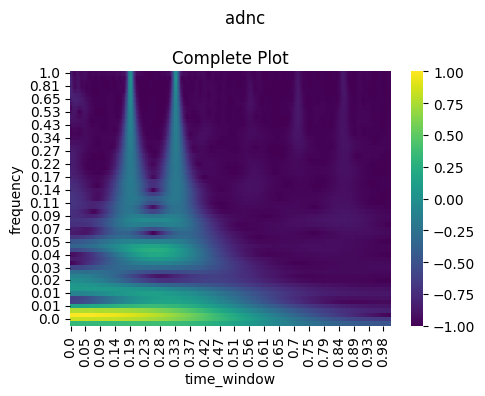

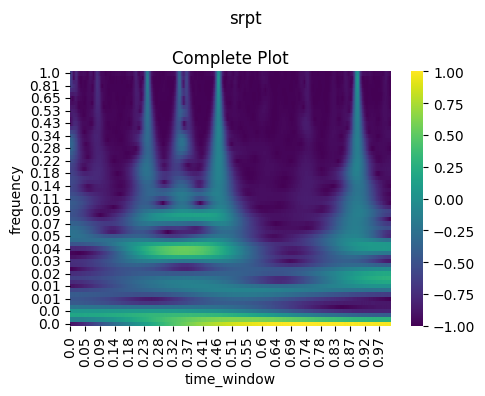

In [4]:
for stock_name, stock_dict in manip_features.items():
    color_plot(stock_dict, stock_name)

### 3d Visualization

In [5]:
stock_name = 'srpt'
plot_against = 'frequency'
hue_var = 'target'
feature_matrix = manip_features[stock_name]['features']

plot3d_dataset(feature_matrix, stock_name, plot_against, hue_var)

### Train autoencoder and get embedding

Epoch 1/3 | Loss: 0.0010602756047319148
Epoch 2/3 | Loss: 0.00037738374685971504
Epoch 3/3 | Loss: 0.0003594991028855128


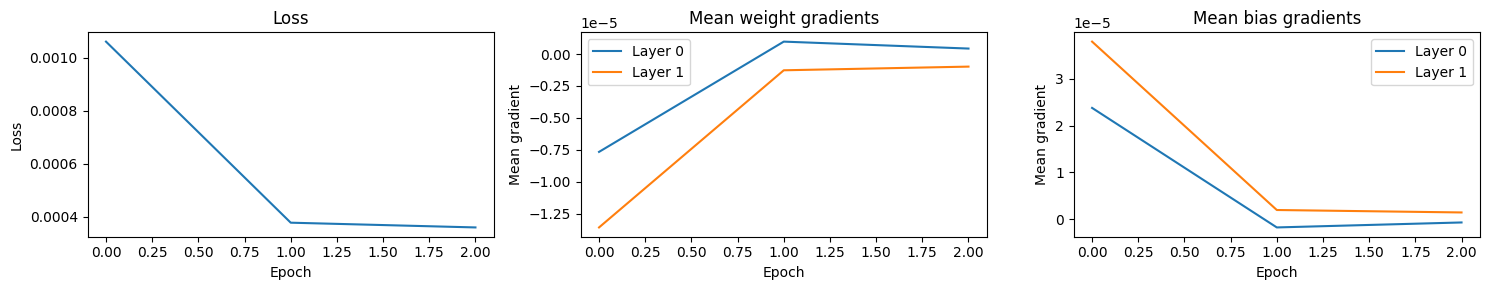

In [6]:
feature_matrices = [
    stock_dict['features'][:, :-2]
    for _, stock_dict in manip_features.items()
]

stacked_feature_matrix = np.vstack(feature_matrices)

autoencoder = create_autoencoder(num_features=stacked_feature_matrix.shape[1], num_hidden_units=3, learning_rate=1)

trained_autoencoder, train_history, _, _ = train_model(
    autoencoder, stacked_feature_matrix, stacked_feature_matrix, num_epochs=3, batch_size=1, verbose=True
)

plot_training_history(train_history, True, stacked_feature_matrix.shape[0])

### Sampling

In [7]:
percentage_to_sample = 10000 / stacked_feature_matrix.shape[0]
train_x_all, train_y, val_x_all, val_y, test_x_all, test_y = joint_random_sampling(manip_features, percentage_to_sample, 0.5, 'uniform', False)

train_x = train_x_all[:, :-1]
val_x = val_x_all[:, :-1]
test_x = test_x_all[:, :-1]

### Get embeddings

In [8]:
train_embedding = get_autoencoder_embedding(trained_autoencoder, train_x.T).T
val_embedding = get_autoencoder_embedding(trained_autoencoder, val_x.T).T
test_embedding = get_autoencoder_embedding(trained_autoencoder, test_x.T).T

### Unsupervised Clustering

In [13]:
sigma_squared = 1.1
beta_squared = sigma_squared*1.5
mountain_clustering = MountainClustering(number_of_partitions=10,
                                        distance_metric='euclidean',
                                        sigma_squared=sigma_squared,
                                        beta_squared=beta_squared,)

mountain_clustering.fit(train_x)

MountainClustering(beta_squared=1.6500000000000001, sigma_squared=1.1)

In [22]:
mountain_centers = np.unique(mountain_clustering.centers_, axis=0)

def get_membership_function(centers, destructive_parameter):

    membership_function = []
    for cluster_dimension in centers.T:
        for cluster_num, cluster_mean in enumerate(cluster_dimension):

            if cluster_num == 0:
                dimension_dict = {}

            cluster_name = f"Cluster_{cluster_num}"
            dimension_dict[cluster_name] = {"mean": cluster_mean, "sigma": destructive_parameter}

            if cluster_num == len(cluster_dimension) - 1:
                membership_function.append(dimension_dict)

In [21]:
membership_function

[{'Cluster_0': {'mean': 0.0, 'sigma': 1.6500000000000001},
  'Cluster_1': {'mean': 0.0, 'sigma': 1.6500000000000001},
  'Cluster_2': {'mean': 0.0, 'sigma': 1.6500000000000001},
  'Cluster_3': {'mean': 0.0, 'sigma': 1.6500000000000001},
  'Cluster_4': {'mean': 0.3333333333333333, 'sigma': 1.6500000000000001},
  'Cluster_5': {'mean': 0.5555555555555556, 'sigma': 1.6500000000000001}},
 {'Cluster_0': {'mean': 0.0, 'sigma': 1.6500000000000001},
  'Cluster_1': {'mean': 0.0, 'sigma': 1.6500000000000001},
  'Cluster_2': {'mean': 0.0, 'sigma': 1.6500000000000001},
  'Cluster_3': {'mean': 0.0, 'sigma': 1.6500000000000001},
  'Cluster_4': {'mean': 0.2222222222222222, 'sigma': 1.6500000000000001},
  'Cluster_5': {'mean': 0.2222222222222222, 'sigma': 1.6500000000000001}},
 {'Cluster_0': {'mean': 0.0, 'sigma': 1.6500000000000001},
  'Cluster_1': {'mean': 0.0, 'sigma': 1.6500000000000001},
  'Cluster_2': {'mean': 0.0, 'sigma': 1.6500000000000001},
  'Cluster_3': {'mean': 1.0, 'sigma': 1.6500000000000

In [55]:
r_a = 1.1
substractive_clustering = SubstractiveClustering(r_a=r_a,
                                                r_b=1.5*r_a,
                                                distance_metric='euclidean',)
substractive_clustering.fit(train_x)

AttributeError: 'SubstractiveClustering' object has no attribute 'distance_metric'

AttributeError: 'SubstractiveClustering' object has no attribute 'distance_metric'